## Simulate/Import Data

In [55]:
dataset_choice = 'custom' # options: telemetrum, telemega, custom

In [56]:
# Import libraries and functions, define natural constants
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import flight_simulation
from IPython.display import display

mach_number_fn = flight_simulation.mach_number_fn
temp_at_height = flight_simulation.temp_at_height
pressure_at_height = flight_simulation.pressure_at_height
air_density_fn = flight_simulation.air_density_fn
lookup_dynamic_viscosity = flight_simulation.lookup_dynamic_viscosity

F_gravity = 9.80665 # m/s^2
m_to_ft_conversion = 3.28084 # ft/m

In [57]:
# Simulate custom flight

# Set custom flight parameters
if dataset_choice == 'custom':
    Prometheus_model = False # set to False if simulating another rocket. Prometheus paramaters are the default in flight_simulation.py
    if Prometheus_model:
        rocket = flight_simulation.Prometheus
    else: # if simulating another rocket, set these parameters
        L_rocket = 2.77 # m
        A_rocket = 0.015326 # 5.5" diameter circle's area in m^2
        dry_mass = 18.4 # kg
        # check https://www.thrustcurve.org/ for engine thrust curves and mass burn rates
        engine_thrust_lookup = { # source: https://www.thrustcurve.org/simfiles/5f4294d20002e900000005a0/
                                0:0,
                                0.12:2600,
                                0.21:2482,
                                0.6:2715,
                                0.9:2876,
                                1.2:2938,
                                1.5:2889,
                                1.8:2785,
                                2.1:2573,
                                2.4:2349,
                                2.7:2182,
                                2.99:85,
                                3:0
                                } 
        fuel_mass_lookup = { # source: https://www.thrustcurve.org/simfiles/5f4294d20002e900000005a0/
                            0:3.423,
                            0.12:3.35069,
                            0.21:3.24469,
                            0.6:2.77495,
                            0.9:2.38622,
                            1.2:1.98198,
                            1.5:1.57684,
                            1.8:1.18234,
                            2.1:0.809811,
                            2.4:0.467594,
                            2.7:0.152563,
                            2.99:0.000196996,
                            3:0
                            }
        rocket = flight_simulation.Rocket(L_rocket, A_rocket, dry_mass, fuel_mass_lookup, engine_thrust_lookup, flight_simulation.Prometheus_Cd_function)
# Simulate Flight
    dataset, liftoff_index, launch_rail_cleared_index, burnout_index, apogee_index = flight_simulation.simulate_flight(rocket)
    # Can add in custom launch conditions if desired (launch pad pressure and temperature, rail length and angle), but they should be nearly the same as last comp. Could be nice to do a sensitivity analysis on these parameters

In [58]:
# If experimental dataset, import data, clean data, fix temperature, set constants, and if telemega, fix speed
 # add support to add in other datasets that will be treated like telemetrum and telemega. want to compare ORK sim csv exports to custom
if dataset_choice == 'telemetrum':
    dataset = pd.read_csv('2022-06-24-serial-5115-flight-0001.csv',skiprows=range(1,93)).iloc[:-258].drop_duplicates().reset_index()
    dataset['time'] = dataset['time'] - dataset['time'][0]

elif dataset_choice == 'telemega':
    dataset = pd.read_csv('2022-06-24-serial-6583-flight-0003.csv',skiprows=range(1,80)).iloc[:-216].drop_duplicates().reset_index()
    dataset['time'] = dataset['time'] - dataset['time'][0]

    # approximate velocity based on derivative of height data for missing points in the TeleMega data (TeleMega didn't start capturing velocity data until apogee)
    num_to_smooth_by = 7 # speed quite far off of TeleMetrum. Maybe try going back to acceleration based
    for i in range(num_to_smooth_by):
        dataset.at[i, 'speed'] = np.float64(0)
    for i in range(len(dataset)-num_to_smooth_by):
        if dataset['speed'][i] == '     NaN': 
            prev_points = 0
            following_points = 0
            for j in range(num_to_smooth_by):
                prev_points = prev_points + dataset['height'][i-j]
                following_points = following_points + dataset['height'][i+j]
            average_prev = prev_points/num_to_smooth_by
            average_following = following_points/num_to_smooth_by
            dataset.at[i, 'speed'] = (average_following-average_prev)/(dataset['time'][i+num_to_smooth_by]-dataset['time'][i-num_to_smooth_by])
    dataset['speed'] = pd.to_numeric(dataset['speed'])

if dataset_choice in ['telemetrum','telemega']:
    len_characteristic = 2.229 # length of Prometheus in m
    # Correct temperatures to what the temperature would be on the outside of the rocket using the standard temperature lapse rate
    dataset['temperature'] = dataset['height'].apply(lambda x: temp_at_height(x,dataset['temperature'][0]))
    # Calculate pressure, air density, dynamic viscosity, Reynolds number, and drag coefficient
    pressure_at_launchpad = dataset['pressure'][0]
    dataset['pressure'] = dataset['height'].apply(lambda x: pressure_at_height(x,dataset['temperature'][0], pressure_at_launchpad))
    dataset['air_density'] = dataset.apply(lambda x: air_density_fn(x['pressure'],x['temperature']), axis=1)
    dataset['q'] = dataset.apply(lambda x: 0.5*x['air_density']*pow(x['speed'],2), axis=1)
    dataset['dynamic_viscosity'] = dataset['temperature'].apply(lambda x: lookup_dynamic_viscosity(x))
    dataset['reynolds_num'] = dataset.apply(lambda x: (x['air_density']*x['speed']*len_characteristic)/x['dynamic_viscosity'], axis=1)
    Cd_rocket_at_Re = flight_simulation.Prometheus_Cd_function
    A_rocket = 0.015326 # 5.5" diameter circle's area in m^2
    dry_mass = 16.91
    # Set vertical velocity and acceleration to the measured totals (sensors didn't record vertical and horizontal separately)
    dataset['v_y'] = dataset['speed']
    dataset['v_x'] = 0
    dataset['a_y'] = dataset['acceleration']
    dataset['a_x'] = 0
    # Set first two indices
    liftoff_index = 0
    for i in range(len(dataset)):
        if dataset['height'][i] > 5.2*np.cos(np.deg2rad(84)):
            launch_rail_cleared_index = i
            break

## Ascent Overview

We don't care about what happens after apogee; that's when our job finishes. We'll want to finish retracting by apogee, but at that point we're finished

In [59]:
imperial = True

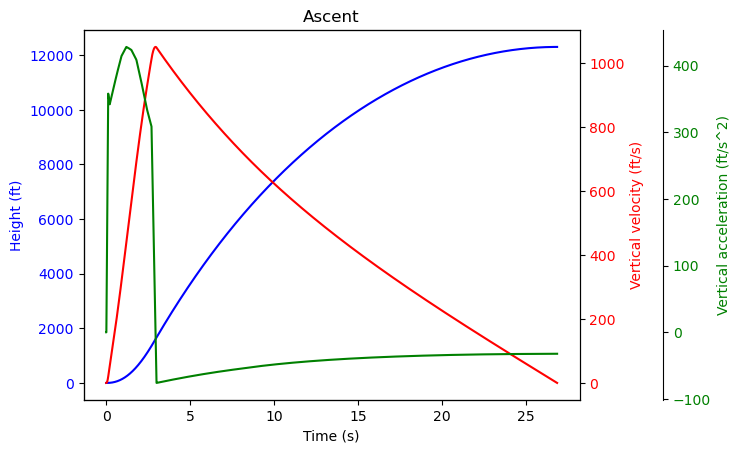

,Time (s),Height (ft),Vertical velocity (ft/s),Speed (ft/s),Vertical accel (ft/s^2),G-force (g),Re*10^7,Mach,q (kPa)
Liftoff,0.01,0.00,0.00,0.01,3.47,0.16,0.00,0.00,0.00
Off Launch Rail,0.37,17.10,108.88,109.61,359.80,11.26,0.48,0.10,0.54
Max-g Force,1.20,239.40,438.74,442.46,427.91,13.43,1.92,0.38,8.84
Max Re,2.92,1583.92,1049.36,1059.71,24.37,0.80,4.47,0.92,48.93
Max q,2.93,1592.32,1049.51,1059.87,14.18,0.49,4.47,0.92,48.93
Max Speed,2.94,1603.86,1049.58,1059.95,0.17,0.14,4.47,0.92,48.93
Burnout,3.00,1666.79,1047.25,1057.63,-75.90,2.37,4.46,0.92,48.64
Apogee,26.88,12301.95,-0.01,94.66,-32.17,1.00,0.31,0.09,0.29


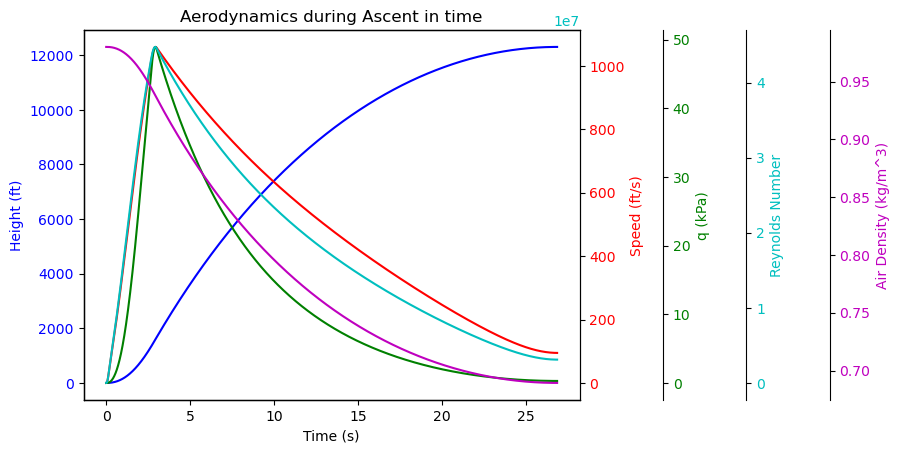

In [60]:
# Analyze Ascent
if dataset_choice in ['telemetrum','telemega']:
    # last 5 data points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset['height'].idxmax()-5

time = dataset['time'][:apogee_index]
height = dataset['height'][:apogee_index].copy()
speed = dataset['speed'][:apogee_index].copy()
v_y = dataset['v_y'][:apogee_index].copy()
a_y = dataset['a_y'][:apogee_index].copy()
a_x = dataset['a_x'][:apogee_index].copy()
g_force = np.sqrt(a_y**2 + a_x**2)/F_gravity

unit = 'm'
if imperial: 
    height *= m_to_ft_conversion
    speed *= m_to_ft_conversion
    v_y *= m_to_ft_conversion
    a_y *= m_to_ft_conversion
    a_x *= m_to_ft_conversion
    unit = 'ft'

fig, ax1 = plt.subplots()
ax1.plot(time, height, color='b')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, v_y, color='r')
ax2.set_ylabel(f'Vertical velocity ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(time, a_y, color='g')
ax3.set_ylabel(f'Vertical acceleration ({unit}/s^2)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

plt.title('Ascent')
plt.show()

max_g_index = g_force.idxmax()
max_speed_index = speed.idxmax()
if dataset_choice != 'custom': 
    dataset['Cd_rocket'] = dataset['reynolds_num'].apply(lambda x: Cd_rocket_at_Re(x))
    dataset['drag_force'] = dataset['q'] * dataset['Cd_rocket'] * A_rocket
    dataset['accel_plus_Fg_minus_drag'] = dataset['a_y'] + F_gravity + dataset['drag_force']/dry_mass
    burnout_index = dataset['time'][dataset['accel_plus_Fg_minus_drag'].apply(lambda x: x < 0)].idxmin()
max_q_index = dataset['q'][:apogee_index].idxmax()
max_Re_index = dataset['reynolds_num'][:apogee_index].idxmax()

parameters_at_flight_events = pd.DataFrame({
    'Time (s)': [round(time.iloc[liftoff_index],2), round(time.iloc[launch_rail_cleared_index],2), round(time.iloc[max_g_index],2), round(time.iloc[max_Re_index],2), round(time.iloc[max_q_index],2), round(time.iloc[max_speed_index],2), round(time.iloc[burnout_index],2), round(time.iloc[-1],2)],
    f'Height ({unit})': [round(height.iloc[liftoff_index],2), round(height.iloc[launch_rail_cleared_index],2), round(height.iloc[max_g_index],2), round(height.iloc[max_Re_index],2), round(height.iloc[max_q_index],2), round(height.iloc[max_speed_index],2), round(height.iloc[burnout_index],2), round(height.iloc[-1],2)],
    f'Vertical velocity ({unit}/s)': [round(v_y.iloc[liftoff_index],2), round(v_y.iloc[launch_rail_cleared_index],2), round(v_y.iloc[max_g_index],2), round(v_y.iloc[max_Re_index],2), round(v_y.iloc[max_q_index],2), round(v_y.iloc[max_speed_index],2), round(v_y.iloc[burnout_index],2), round(v_y.iloc[-1],2)],
    f'Speed ({unit}/s)': [round(speed.iloc[liftoff_index],2), round(speed.iloc[launch_rail_cleared_index],2), round(speed.iloc[max_g_index],2), round(speed.iloc[max_Re_index],2), round(speed.iloc[max_q_index],2), round(speed.iloc[max_speed_index],2), round(speed.iloc[burnout_index],2), round(speed.iloc[-1],2)],
    f'Vertical accel ({unit}/s^2)': [round(a_y.iloc[liftoff_index],2), round(a_y.iloc[launch_rail_cleared_index],2), round(a_y.iloc[max_g_index],2), round(a_y.iloc[max_Re_index],2), round(a_y.iloc[max_q_index],2), round(a_y.iloc[max_speed_index],2), round(a_y.iloc[burnout_index],2), round(a_y.iloc[-1],2)],
    f'G-force (g)': [round(g_force.iloc[liftoff_index],2), round(g_force.iloc[launch_rail_cleared_index],2), round(g_force.iloc[max_g_index],2), round(g_force.iloc[max_Re_index],2), round(g_force.iloc[max_q_index],2), round(g_force.iloc[max_speed_index],2), round(g_force.iloc[burnout_index],2), round(g_force.iloc[-1],2)],
    f'Re*10^7': [round(dataset['reynolds_num'].iloc[liftoff_index]/pow(10,7),2), round(dataset['reynolds_num'].iloc[launch_rail_cleared_index]/pow(10,7),2), round(dataset['reynolds_num'].iloc[max_g_index]/pow(10,7),2), round(dataset['reynolds_num'].iloc[max_Re_index]/pow(10,7),2), round(dataset['reynolds_num'].iloc[max_q_index]/pow(10,7),2), round(dataset['reynolds_num'].iloc[max_speed_index]/pow(10,7),2), round(dataset['reynolds_num'].iloc[burnout_index]/pow(10,7),2), round(dataset['reynolds_num'].iloc[-1]/pow(10,7),2)],
    f'Mach': [round(mach_number_fn(dataset['speed'].iloc[liftoff_index],dataset['temperature'].iloc[liftoff_index]),2), round(mach_number_fn(dataset['speed'].iloc[launch_rail_cleared_index],dataset['temperature'].iloc[launch_rail_cleared_index]),2), round(mach_number_fn(dataset['speed'].iloc[max_g_index],dataset['temperature'].iloc[max_g_index]),2), round(mach_number_fn(dataset['speed'].iloc[max_Re_index],dataset['temperature'].iloc[max_Re_index]),2), round(mach_number_fn(dataset['speed'].iloc[max_q_index],dataset['temperature'].iloc[max_q_index]),2), round(mach_number_fn(dataset['speed'].iloc[max_speed_index],dataset['temperature'].iloc[max_speed_index]),2), round(mach_number_fn(dataset['speed'].iloc[burnout_index],dataset['temperature'].iloc[burnout_index]),2), round(mach_number_fn(dataset['speed'].iloc[-1],dataset['temperature'].iloc[-1]),2)],
    f'q (kPa)': [round(dataset['q'].iloc[liftoff_index]/1000,2), round(dataset['q'].iloc[launch_rail_cleared_index]/1000,2), round(dataset['q'].iloc[max_g_index]/1000,2), round(dataset['q'].iloc[max_Re_index]/1000,2), round(dataset['q'].iloc[max_q_index]/1000,2), round(dataset['q'].iloc[max_speed_index]/1000,2), round(dataset['q'].iloc[burnout_index]/1000,2), round(dataset['q'].iloc[-1]/1000,2)],
}, 
index=['Liftoff', 'Off Launch Rail', 'Max-g Force', 'Max Re', 'Max q', 'Max Speed', 'Burnout', 'Apogee'])
display(parameters_at_flight_events.sort_values(by=['Time (s)']))

# Aerodynamics during ascent

# note: plotting pressure against hieght of both Prometheus datasets on both ascent and descent shows them to be nearly identical. Given the significant change in speed on the way up vs the way down, this suggests that the pressure inside the av bay (which is what's read by the sensors) changes nearly instantaneously with the pressure outside, at least as far as it makes a difference for the changing rates in the max-q calculation. <- check if also consistent with other sim, note if it is

fig, ax1 = plt.subplots()
ax1.plot(time, height, color='b', label='Height')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, speed, color='r', label='Speed')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(time, dataset['q'][0:apogee_index]/1000, color='g', label='q')
ax3.set_ylabel('q (kPa)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(time, dataset['reynolds_num'][0:apogee_index], color='c', label='Reynolds Number')
ax4.set_ylabel('Reynolds Number', color='c')
ax4.tick_params(axis='y', labelcolor='c')

ax5 = ax1.twinx()
ax5.spines['right'].set_position(('outward', 180))
ax5.plot(time, dataset['air_density'][0:apogee_index], color='m', label='Air Density')
ax5.set_ylabel('Air Density (kg/m^3)', color='m')
ax5.tick_params(axis='y', labelcolor='m')

plt.title('Aerodynamics during Ascent in time')
plt.show()

## Airbrakes Simulation

In [61]:
# Simulate airbrakes flight

# Set flightpath until airbrake deployment as identical
airbrake_deployment = burnout_index + 1
pre_brake_flight = dataset.head(airbrake_deployment).copy()

# Define airbrake parameters
num_flaps = 3
A_flap = 0.0064516 # 0.011408 is the current area in CAD, likely to decrease. 0.0064516 from Maryland's last year, which we'll probably have a similar configuration to
Cd_brakes = 1 # about what other teams had, super rough
max_deployment_speed = 10 #deg/s
custom_airbrakes = flight_simulation.Airbrakes(num_flaps, A_flap, Cd_brakes, max_deployment_speed)

if dataset_choice in ['telemetrum','telemega']:
    timestep = 0.01
else:
    timestep = 0.001

ascent = flight_simulation.simulate_airbrakes_flight(pre_brake_flight, rocket = rocket, airbrakes = custom_airbrakes, timestep = timestep)
# how high should the rocket overshoot without deployment, motor selction

,Time (s),Height (ft),Speed (ft/s),Accel (ft/s^2),G-force (g)
Airbrakes Apogee,21.19,8996.47,63.64,-32.17,1.0
No Airbrakes Apogee,26.88,12301.95,94.66,-32.17,1.0
Delta,-5.69,-3305.48,-31.02,0.00,0.0


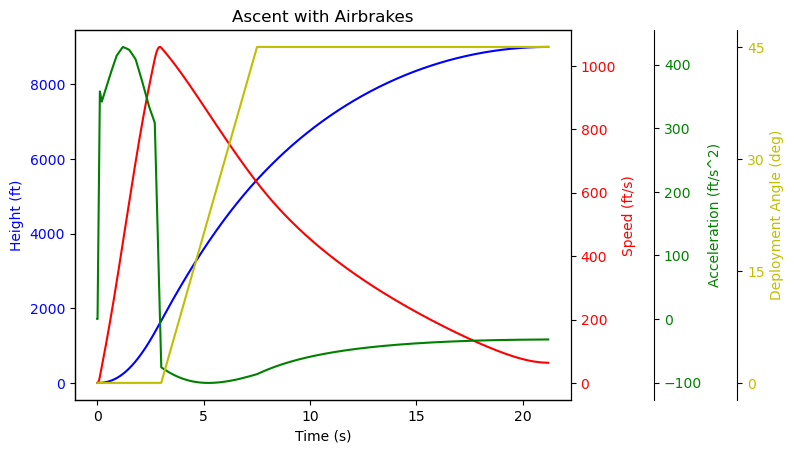

In [63]:
# Analyze ascent
height = ascent['height'].copy()
speed = ascent['speed'].copy()
accel = ascent['a_y'].copy()
apogee = ascent['height'].iloc[-1]
unit = 'm'
if imperial: 
    height *= m_to_ft_conversion
    speed *= m_to_ft_conversion
    accel *= m_to_ft_conversion
    apogee *= m_to_ft_conversion
    unit = 'ft'

# df with deltas
parameters_at_apogee = pd.DataFrame({
    'Time (s)': [round(ascent['time'].iloc[-1],2), round(parameters_at_flight_events.iloc[-1].iloc[0],2)],
    f'Height ({unit})': [round(height.iloc[-1],2), round(parameters_at_flight_events.iloc[-1].iloc[1],2)],
    f'Speed ({unit}/s)': [round(speed.iloc[-1],2), round(parameters_at_flight_events.iloc[-1].iloc[3],2)],
    f'Accel ({unit}/s^2)': [round(accel.iloc[-1],2), round(parameters_at_flight_events.iloc[-1].iloc[4],2)],
    f'G-force (g)': [round(abs(ascent['a_y'].iloc[-1]/F_gravity),2), round(parameters_at_flight_events.iloc[-1].iloc[5],2)]
}, 
index=['Airbrakes Apogee', 'No Airbrakes Apogee'])

delta_values = parameters_at_apogee.loc['Airbrakes Apogee'] - parameters_at_apogee.loc['No Airbrakes Apogee']
parameters_at_apogee.loc['Delta'] = delta_values
display(parameters_at_apogee)

# Plot ascent
fig, ax1 = plt.subplots()
ax1.plot(ascent['time'], height, color='b')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(ascent['time'], speed, color='r')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(ascent['time'], accel, color='g')
ax3.set_ylabel(f'Acceleration ({unit}/s^2)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(ascent['time'], ascent['deployment_angle'], color='y')
ax4.set_ylabel(f'Deployment Angle (deg)', color='y')
ax4.tick_params(axis='y', labelcolor='y')
ax4.set_yticks(range(0, 46, 15))

plt.title('Ascent with Airbrakes')
plt.show()